# Подход 1: градиентный бустинг "в лоб"

In [1]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, ensemble, metrics
import time
import datetime

# 1.1 Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, 
#     cвязанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
features = pd.read_csv(r'C:\temp\features.csv', index_col='match_id')
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16,2449,0,4,1974,3,63


In [2]:
# Удаляем признаки, которых нет в тестовой выборке данных
# duration, tower_status_radiant, tower_status_dire, barracks_status_radiant, barracks_status_dire
featuresAdapted = features.drop(['duration','tower_status_radiant',
                          'tower_status_dire','barracks_status_radiant',
                          'barracks_status_dire'], axis = 1)

In [3]:
# 1.2 Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число 
#     заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте 
#     для любых двух из них дать обоснование, почему их значения могут быть пропущены.
features_uncompleted = featuresAdapted.count()
features_uncompleted[features_uncompleted < featuresAdapted['start_time'].size]

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

Пропуски в столбце 'first_blood_time' могут быть объяснены тем, что очень низка вероятность в течение первых пяти минут убить вражеского героя.
Пропуски в столбце 'radiant_courier_time' объясняются тем, что маловероятно, что какой-то игрок может сделать за первые 5 минут покупку предмета courier.

In [4]:
# 1.3 Замените пропуски на нули с помощью функции fillna().
featuresAdapted.fillna(0, inplace=True)

features_uncompleted = featuresAdapted.count()
features_uncompleted[features_uncompleted < featuresAdapted['start_time'].size]

Series([], dtype: int64)

### 2 Как называется столбец, содержащий целевую переменную?

Столбец, содержащий целевую переменную, - это radiant_win, т.к. содержит информацию о том, какая из команд победила в этой игре, что и составляет задачу данного задания.

In [5]:
# Подготовим столбец с целевой переменной и матрицу признаков
targetColumn = featuresAdapted.radiant_win.values
featuresAdapted.drop('radiant_win', axis = 1, inplace = True)
featuresMatrix = featuresAdapted.as_matrix()

## Градиентный бустинг

In [6]:
treeQtys = [10, 20, 30, 40, 50]
learningRts = [0.1, 0.2, 0.3, 0.5, 1]
precisions = []

timeElapsed = []

for lr in learningRts:
    for tq in treeQtys:
        kF = cross_validation.KFold(len(targetColumn), n_folds = 5, shuffle = True, random_state = 42)
        gBC = ensemble.GradientBoostingClassifier(n_estimators = tq, learning_rate = lr, max_depth = 2, random_state = 241)

        startTime = datetime.datetime.now()
        
        scoreMean = cross_validation.cross_val_score(gBC, featuresMatrix, targetColumn, scoring = 'roc_auc', cv = kF).mean()
        
        elapsedTime = datetime.datetime.now() - startTime
        print lr, tq, elapsedTime, scoreMean
        # только для 0.1
        if lr == learningRts[0]:
            timeElapsed.append(elapsedTime.total_seconds())
        
        precisions.append(scoreMean)

0.1 10 0:00:45.295000 0.648783745881
0.1 20 0:01:28.790000 0.67342168366
0.1 30 0:02:15.077000 0.682421704838
0.1 40 0:03:01.646000 0.687770411906
0.1 50 0:03:47.675000 0.691396591851
0.2 10 0:00:47.491000 0.666617456668
0.2 20 0:01:32.953000 0.684813025173
0.2 30 0:02:20.297000 0.691997080521
0.2 40 0:03:05.182000 0.696549177931
0.2 50 0:03:54.376000 0.699819478408
0.3 10 0:00:47.376000 0.677094863854
0.3 20 0:01:33.274000 0.691088495322
0.3 30 0:02:20.306000 0.697190157051
0.3 40 0:03:06.463000 0.701168752079
0.3 50 0:03:53.762000 0.704265247283
0.5 10 0:00:47.737000 0.678461991332
0.5 20 0:01:33.912000 0.69228652845
0.5 30 0:02:20.600000 0.69961241769
0.5 40 0:03:06.866000 0.703299058399
0.5 50 0:03:52.526000 0.705833859529
1 10 0:00:47.301000 0.680372014065
1 20 0:01:33.620000 0.69383956825
1 30 0:02:19.404000 0.697884462539
1 40 0:03:08.229000 0.700977674025
1 50 0:03:51.290000 0.70387557812


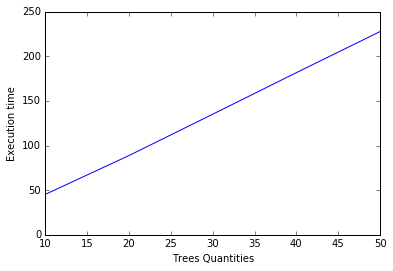

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(xLabel, yLabel, x, y):
    fig = plt.figure()

    plt.plot(x, y)
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    
    plt.show()

plot('Trees Quantities', 'Execution time', treeQtys, timeElapsed)

### 3 Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось?

Время валидации зависит от количества деревьев, но слабо от скорости обучения. Есть также зависимость от производительности процессора и других параллельных вычислительных процессов. Но в среднем время валидации для 30 деревьев составило около 2 минут и 30 секунд. Глубина деревьев 2, при увеличении глубины время существенно растет.

Качество растет при увеличени скорости обучение, но незначительно от 0.68 до 0.70.

### 4 Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

С увеличением числа деревьев время обучение и валидации растет близко к линейному закону, в том время как точность увеличивается несущественно во втором знаке после запятой. Для ускорения обучения можно уменьшить или объединить часть признаков и ограничить глубину деревьев 2.

# Подход 2: логистическая регрессия

In [6]:
# 2.1 Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) 
#     с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите 
#     при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится 
#     с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая 
#     регрессия по сравнению с градиентным бустингом?

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

def findBestCForLR(cs, features, target):
    
    scores = []
    elapsed = []
    
    bestC = -1000
    maxScore = -1000
    for c in cs:
        kF = cross_validation.KFold(len(target), n_folds = 5, shuffle = True, random_state = 241)
        lRC = LogisticRegression(C = c)
        
        startTime = datetime.datetime.now()
        
        scoreMean = cross_validation.cross_val_score(lRC, features, target, scoring = 'roc_auc', cv = kF).mean()
        
        time = datetime.datetime.now() - startTime
        elapsed.append(time.total_seconds())
        
        scores.append(scoreMean)
                 
        if scoreMean > maxScore:
            maxScore = scoreMean
            bestC = c
            
    return [bestC, elapsed, scores]

cs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

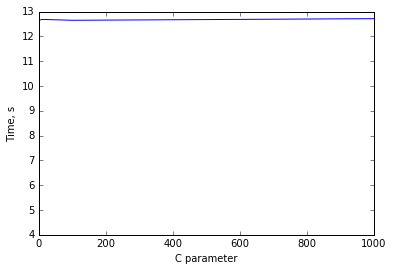

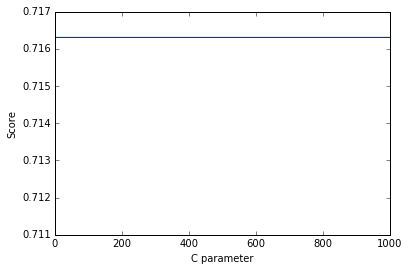

Лучший С = 0.01
Max качество = 0.716341465365
Min качество = 0.711250115451


In [12]:
scaledFeatures = preprocessing.scale(featuresMatrix)
bestC, time, scores = findBestCForLR(cs, scaledFeatures, targetColumn)

plot('C parameter', 'Time, s', cs, time)
plot('C parameter', 'Score', cs, scores)
print 'Лучший С =', bestC
print 'Max качество =', np.max(scores)
print 'Min качество =', np.min(scores)

### Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

У логистической регрессии качество равно 0.72 против лучшего для градиентного бустинга равного 0.71. Разница не велика, в сотых. Скорость работы логистической кривой существенно выше, что делает ее более предпочтительной для использования.

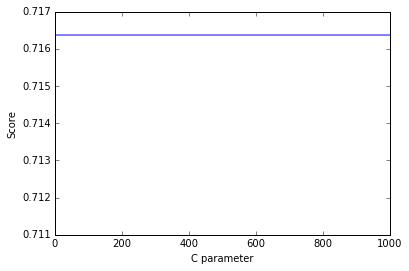

Лучший С = 0.01
Max качество = 0.716400950653
Min качество = 0.711248389557


In [13]:
# 2.2 Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является 
#     хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, 
#     d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии 
#     на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

withoutCategories = featuresAdapted.drop(['lobby_type','r1_hero','r2_hero','r3_hero',
                                          'r4_hero','r5_hero','d1_hero','d2_hero',
                                          'd3_hero', 'd4_hero', 'd5_hero'], axis = 1).as_matrix()

scaledWithoutCategories = preprocessing.scale(withoutCategories)
bestC, time, scores = findBestCForLR(cs, scaledWithoutCategories, targetColumn)

plot('C parameter', 'Score', cs, scores)
print 'Лучший С =', bestC
print 'Max качество =', np.max(scores)
print 'Min качество =', np.min(scores)

### Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

Удаление категориальных признаков приводит к незначительному повышению качества, но очень очень незначительному:  0.716400950653, против 0.716341465365 - без удаления категорий. Значения категориальных признаков несильно отличается от нуля (по сравнению с другими например), потому их исключение и не изменила общей наблюдаемой картины.

In [9]:
# 2.3 На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои 
#     играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают 
#     чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может 
#     пригодиться фукнция unique или value_counts)

heroes = featuresAdapted[['r1_hero','r2_hero','r3_hero',
                          'r4_hero','r5_hero','d1_hero',
                          'd2_hero','d3_hero','d4_hero','d5_hero']]
heroQtys = np.max(pd.unique(heroes.as_matrix().ravel()))
print 'Количество разных героев =', heroQtys

Количество разных героев = 112


### Сколько различных идентификаторов героев существует в данной игре?

112

In [10]:
# 2.4 Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N 
#     различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал 
#     в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду 
#     Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к 
#     числовым, которые вы использовали во втором пункте данного этапа.

def formBag(data, N):
    bag = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in xrange(5):
            bag[i, data.ix[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
            bag[i, data.ix[match_id, 'd%d_hero' % (p + 1)] - 1] = -1
    
    return bag

In [11]:
wordsBag = np.hstack((withoutCategories, formBag(heroes, heroQtys)))

C:\Users\edart\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


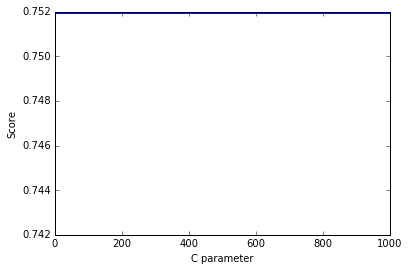

Лучший С = 0.01
Max качество = 0.751970490091
Min качество = 0.742839117639


In [12]:
# 2.5 Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. 
#     Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

scaledWordsBag = preprocessing.scale(wordsBag)

bestC, time, scores = findBestCForLR(cs, scaledWordsBag, targetColumn)
plot('C parameter', 'Score', cs, scores)
print 'Лучший С =', bestC
print 'Max качество =', np.max(scores)
print 'Min качество =', np.min(scores)

### Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

Да, произошло заметное улучшение. И хотя оно в пределах нескольких процентов, но заметнее, чем результат удаления категориальных признаков. Потому можно сказать, что эта лучшая из рассмотренных моделей. Объясняется это тем, что признак становится числовым, что увеличивает его информативность и улучшает возможность обучения 

In [13]:
# 2.6 Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных 
#     моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — 
#     находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

# Готовим тестовую выборку к использованию в лучшей модели с мешком слов, т.е.
# получаем выборку
featuresTest = pd.read_csv(r'C:\temp\features_test.csv', index_col = 'match_id')
# заполняем пропущенные значения
featuresTest.fillna(0, inplace=True)
# готов мешок слов
withoutCategoriesTest = featuresTest.drop(['lobby_type','r1_hero','r2_hero','r3_hero',
                                          'r4_hero','r5_hero','d1_hero','d2_hero',
                                          'd3_hero', 'd4_hero', 'd5_hero'], axis = 1).as_matrix()
heroes = featuresTest[['r1_hero','r2_hero','r3_hero',
                          'r4_hero','r5_hero','d1_hero',
                          'd2_hero','d3_hero','d4_hero','d5_hero']]
heroQtys = np.max(pd.unique(heroes.as_matrix().ravel()))

wordsBagTest = np.hstack((withoutCategoriesTest, formBag(heroes, heroQtys)))

In [14]:
scaledWordsBagTest = preprocessing.scale(wordsBagTest)

In [16]:
# обучаем выборку с найденным параметром регуляризации
nlRC = LogisticRegression(C = bestC)
nlRC.fit(scaledWordsBag, targetColumn)

# выполняем предсказание по выборке
prediction = nlRC.predict_proba(scaledWordsBagTest)[:, 0]

In [17]:
# вормируем результат
result = pd.DataFrame(prediction, index = featuresTest.index, columns = ['radiant_win'])
result.to_csv(r'C:\temp\prediction.csv', sep = ',', encoding = 'utf-8')

In [18]:
result

,radiant_win
match_id,
6,0.177311
7,0.243982
10,0.811342
13,0.143254
16,0.758544
18,0.619692
19,0.472633
24,0.437271
33,0.784179
